In [52]:
import utils_image
print(f"Image utils: {[x for x in dir(utils_image) if x[:5] == 'image']}")
import os
import random
import pathlib
import IPython.display as display
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from tensorflow import keras
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"TensorFlow version: {tf.__version__}")

Image utils: ['image_display', 'image_display_v2', 'image_download', 'image_labels', 'image_load_preprocessing', 'image_paths']
TensorFlow version: 2.4.1


## 下载数据

In [21]:
data_root = utils_image.image_download(
    data_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    data_fname = "flower_photos",
    untar = True
)
data_root

/Users/zfwang/.keras/datasets/flower_photos/roses
/Users/zfwang/.keras/datasets/flower_photos/sunflowers
/Users/zfwang/.keras/datasets/flower_photos/daisy
/Users/zfwang/.keras/datasets/flower_photos/dandelion
/Users/zfwang/.keras/datasets/flower_photos/tulips
/Users/zfwang/.keras/datasets/flower_photos/LICENSE.txt


PosixPath('/Users/zfwang/.keras/datasets/flower_photos')

## 读取数据

In [22]:
all_image_paths = utils_image.image_paths(data_root)
all_image_paths[:5]

image_count=3670


['/Users/zfwang/.keras/datasets/flower_photos/roses/16209331331_343c899d38.jpg',
 '/Users/zfwang/.keras/datasets/flower_photos/roses/5777669976_a205f61e5b.jpg',
 '/Users/zfwang/.keras/datasets/flower_photos/roses/4860145119_b1c3cbaa4e_n.jpg',
 '/Users/zfwang/.keras/datasets/flower_photos/roses/15011625580_7974c44bce.jpg',
 '/Users/zfwang/.keras/datasets/flower_photos/roses/17953368844_be3d18cf30_m.jpg']

## 查看数据

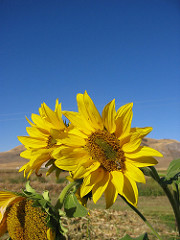

Image (CC BY 2.0)  by David Wiley


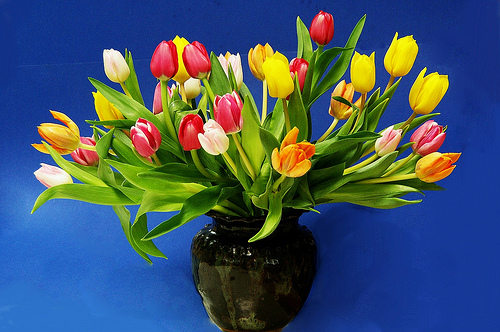

Image (CC BY 2.0)  by Dave Shafer


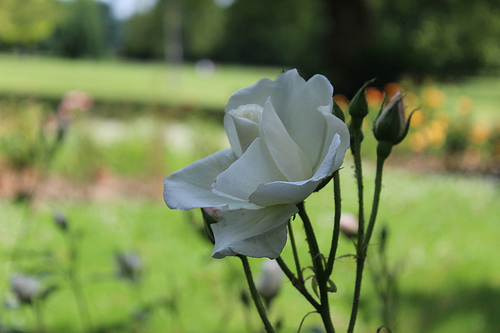

Image (CC BY 2.0)  by Pavlina Jane


In [23]:
def caption_image(image_path):
    attributions = (data_root/"LICENSE.txt").open(encoding = "utf-8").readlines()[4:]
    attributions = [line.split(" CC-BY") for line in attributions]
    attributions = dict(attributions)
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + " - ".join(attributions[str(image_rel)].split(" - ")[:-1])

for n in range(3):
    image_path = random.choice(all_image_paths)
    utils_image.image_display(img_path = image_path)
    print(caption_image(image_path))

## 图像标签

In [24]:
all_label_names, all_label_dict, all_image_labels = utils_image.image_labels(data_root, all_image_paths)
all_label_names
all_label_dict
all_image_labels[:10]

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

## 加载和格式化图片

/Users/zfwang/.keras/datasets/flower_photos/sunflowers/4528959364_fa544b0f4e_m.jpg


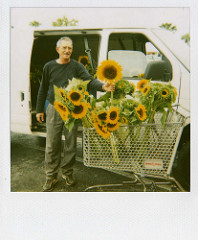

In [25]:
img_path_0 = all_image_paths[1000]
print(img_path_0)
utils_image.image_display(img_path_0)

In [26]:
image_0 = utils_image.image_load_preprocessing(img_path_0)
print(image_0.shape)
print(image_0.numpy().min())
print(image_0.numpy().max())

(192, 192, 3)
0.0
0.9659697


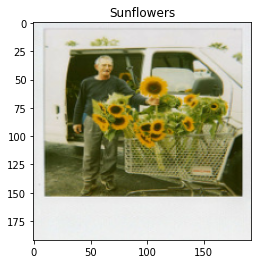

In [27]:
utils_image.image_display_v2(img_path = img_path_0, img_label = all_image_labels[1000], all_label_names = all_label_names)

## 构建 tf.data.Dataset

- all_image_paths
- all_image_label
- all_label_names
- all_label_dict

In [42]:
# print(all_image_paths[:5])
# print(all_image_labels[:5])
# print(all_label_names)
# print(all_label_dict)

In [44]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = path_ds.map(utils_image.image_load_preprocessing, num_parallel_calls = AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_label_ds

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>

In [45]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

def load_and_preprocess_from_path_label(path, label):
    """
    元组被解压缩到映射函数的位置参数中
    """
    return utils_image.image_load_preprocessing(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

## 训练的基本方法，数据

- 被充分打乱
    - `shuffle`
    - 设置一个和数据集大小一致的 shuffle buffer size(随机缓冲区大小)以保证数据被充分打乱
- 被分割为 batch
    - `batch`
- 永远重复
    - `repeat`
- 尽快提供 batch
    - `prefetch`
    - 当模型在训练的时候，prefetch 使数据集在后台取得 batch

In [47]:
# method 1
BATCH_SIZE = 32
image_count = len(all_image_paths)
ds = image_label_ds.shuffle(buffer_size = image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size = AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [50]:
# method 2
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size = image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

## 传递数据集到模型

In [51]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape = (192, 192, 3), include_top = False)
mobile_net.trainable = False

9412608/9406464 [==============================] - 79s 8us/step


In [54]:
def change_range(image, label):
    return 2 * image - 1, label

keras_ds = ds.map(change_range)

In [55]:
image_batch, label_batch = next(iter(keras_ds))
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


In [57]:
model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(all_label_names), activation = "softmax")
])
logit_batch = model(image_batch).numpy()
print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print("shape:", logit_batch.shape)

min logit: 0.004917406
max logit: 0.8555352
shape: (32, 5)


In [59]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)
len(model.trainable_variables)
model.summary()

2

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [61]:
steps_per_epoch = tf.math.ceil(len(all_image_paths) / BATCH_SIZE).numpy()
steps_per_epoch
model.fit(ds, epochs = 1, steps_per_epoch = 3)

115.0

3/3 [==============================] - 8s 231ms/step - loss: 1.9422 - accuracy: 0.1953


## TFRecord

In [62]:
# 1.从原始图片数据中构建出一个 TFRecord 文件
image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths).map(tf.io.read_file)
tfrec = tf.data.experimental.TFRecordWriter("image.tfrec")
tfrec.write(image_ds)
# 2.构建一个从TFRecord 文件读取的数据集，并对图像进行编码、格式化
image_ds = tf.data.TFRecordDataset("image.tfrec").map(utils_image.image_preprocessing)
# 3.压缩数据集
ds = tf.data.Dataset.zip(image_ds, label_ds)
ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size = image_count))
ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

# 序列化的 Tensor
paths_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = paths_ds.map(utils_image.image_load_preprocessing)
ds = image_ds.map(tf.io.serialize_tensor)
tfrec = tf.data.experimental.TFRecordWriter("image.tfrec")
tfrec.write(ds)

ds = tf.data.TFRecordDataset('images.tfrec')
def parse(x):
    result = tf.io.parse_tensor(x, out_type=tf.float32)
    result = tf.reshape(result, [192, 192, 3])
    return result
ds = ds.map(parse, num_parallel_calls = AUTOTUNE)
ds = tf.data.Dataset.zip((ds, label_ds))
ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size = image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

AttributeError: module 'utils_image' has no attribute 'image_preprocessing'